In [ ]:
#. ----- don't run this unless you need TA Lib
!pip install condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge ta-lib
!pip install vectorbt
!pip uninstall -y cffi
!pip uninstall -y _cffi_backend
!pip install cffi==1.17.0
import cffi
import _cffi_backend
print(cffi.__version__)
print(_cffi_backend.__version__)

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...


KeyboardInterrupt: 

In [ ]:
!pip install vectorbt

In [2]:
import vectorbt as vbt
# import talib as ta
import requests
import json
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import time
import datetime

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima



In [3]:
class GetBinanceData:
    @staticmethod
    def get_data(symbol, interval, startDate=datetime.datetime(2020, 1, 1), endDate=datetime.datetime.now()):
        dataList = []
        current_date = datetime.datetime.now()
        start_date = startDate

        delta_units = GetBinanceData.convert_to_minutes(interval)
        print(delta_units)
        delta = datetime.timedelta(minutes=delta_units)

        while start_date < current_date:
            end_date = start_date + delta
            if end_date > current_date:
                end_date = current_date
            # Convert datetime objects to milliseconds
            start_ms = int(start_date.timestamp() * 1000)
            end_ms = int(end_date.timestamp() * 1000)

            start_str = start_date.strftime('%Y-%m-%d %H:%M:%S')
            end_str = end_date.strftime('%Y-%m-%d %H:%M:%S')

            # print(f"Fetching data from {start_str} to {end_str}")
            data = GetBinanceData.get_historical_data(symbol, interval, start_ms, end_ms)
            if data:
                dataList.extend(data)
            start_date = end_date
            time.sleep(1)

        return dataList

    @staticmethod
    def get_historical_data(symbol, interval, start_time, end_time):
        url = f"https://api.binance.us/api/v3/klines"
        params = {
            'symbol': symbol.upper(),
            'interval': interval,
            'startTime': start_time,
            'endTime': end_time,
            'limit': 1000
        }
        # print(params)
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            return data
        else:

            print(f"Failed to fetch data. Status code: {response.json()}")
            return None

    @staticmethod
    def convert_to_minutes(time_str):
        time_mapping = {
            'm': 1,
            'h': 60,
            'd': 1440,
            'w': 10080,
            'M': 43200
        }

        num = int(time_str[:-1])
        unit = time_str[-1]

        return (num * time_mapping[unit])*1000

    def data_to_dataframe(data):
      # Define the column names based on Binance API response
      columns = [
          "timestamp", "open", "high", "low", "close", "volume",
          "Close Time", "Quote Asset Volume", "Number of Trades",
          "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
      ]
      # Convert the data to a pandas DataFrame
      df = pd.DataFrame(data, columns=columns)
      # # Convert timestamp columns to datetime
      # df["timestamp"] = pd.to_datetime(df['timestamp'])
      # df["Close Time"] = pd.to_datetime(df["Close Time"], unit='ms')
      # # Convert numeric columns to float
      # numeric_columns = ["open", "high", "low", "close", "volume", "Quote Asset Volume",
      #                   "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume"]
      # df[numeric_columns] = df[numeric_columns].astype(float)
      return df

    @staticmethod
    def get_data_dataFrame(symbol, interval, startDate=datetime.datetime(2020, 1, 1), endDate=datetime.datetime.now()):
        data = GetBinanceData.get_data(symbol, interval, startDate, endDate)
        return GetBinanceData.data_to_dataframe(data)

In [8]:
Modeldate = datetime.datetime(2024, 1, 1)
date = datetime.datetime(2020, 1, 1)
timeperiod = '1d'

Training Modal MarketData

In [52]:

eth_btc_data = GetBinanceData.get_data("ethusdt", timeperiod, startDate=Modeldate , endDate=datetime.datetime.now())
eth_usdt_data = GetBinanceData.get_data("ethusdt", timeperiod, startDate=Modeldate , endDate=datetime.datetime.now())
btc_usdt_data = GetBinanceData.get_data("btcusdt", timeperiod, startDate=Modeldate , endDate=datetime.datetime.now())

1440000
1440000
1440000


In [83]:
#creating DataFrame
df_eth_btc = GetBinanceData.data_to_dataframe(eth_btc_data)
df_eth_usdt= GetBinanceData.data_to_dataframe(eth_usdt_data)
df_btc_usdt= GetBinanceData.data_to_dataframe(btc_usdt_data)


# df_eth_btc = df_eth_btc.apply(pd.to_numeric, errors='coerce')
# df_eth_usdt = df_eth_usdt.apply(pd.to_numeric, errors='coerce')
# btc_usdt_data = btc_usdt_data.apply(pd.to_numeric, errors='coerce')

In [86]:
df_eth_btc.rename(columns={'close': 'ethbtc_close'}, inplace=True)
df_eth_usdt.rename(columns={'close': 'ethusdt_close'}, inplace=True)
df_btc_usdt.rename(columns={'close': 'btcusdt_close'}, inplace=True)

# Merge the data on the timestamp
data = df_eth_btc[['timestamp', 'ethbtc_close']].merge(
    df_eth_usdt[['timestamp', 'ethusdt_close']], on='timestamp'
).merge(
    df_btc_usdt[['timestamp', 'btcusdt_close']], on='timestamp'
)

# Make sure all data is sorted by time
data = data.sort_values('timestamp').reset_index(drop=True)
# Convert columns to numeric, forcing errors to NaN
data['ethbtc_close'] = pd.to_numeric(data['ethbtc_close'], errors='coerce')
data['ethusdt_close'] = pd.to_numeric(data['ethusdt_close'], errors='coerce')
data['btcusdt_close'] = pd.to_numeric(data['btcusdt_close'], errors='coerce')

# Check for NaN values after conversion
print(data.isnull().sum())


timestamp        0
ethbtc_close     0
ethusdt_close    0
btcusdt_close    0
dtype: int64


In [14]:
df.head()

,timestamp,ethbtc_close,ethusdt_close,btcusdt_close
0,1704067200000,2340.00000000,2340.00000000,43999.99000000
1,1704153600000,2355.61000000,2355.61000000,44953.74000000
2,1704240000000,2209.05000000,2209.05000000,42823.20000000
3,1704326400000,2269.13000000,2269.13000000,44146.81000000
4,1704412800000,2265.47000000,2265.47000000,44167.00000000


In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
# df_eth_btc.rename(columns={'close': 'ethbtc_close'}, inplace=True)
# df_eth_usdt.rename(columns={'close': 'ethusdt_close'}, inplace=True)
# df_btc_usdt.rename(columns={'close': 'btcusdt_close'}, inplace=True)

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Define the SARIMAX model
model = SARIMAX(train['ethbtc_close'],
                 exog=train[['ethusdt_close', 'btcusdt_close']],
                 order=(2, 1, 2),
                 seasonal_order=(0, 0, 0, 0))  # No seasonality for daily data

# Fit the model
results = model.fit()

# Print the model summary
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:           ethbtc_close   No. Observations:                  220
Model:               SARIMAX(2, 1, 2)   Log Likelihood                2309.562
Date:                Tue, 01 Oct 2024   AIC                          -4605.125
Time:                        23:25:39   BIC                          -4581.401
Sample:                             0   HQIC                         -4595.544
                                - 220                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ethusdt_close     1.0000   1.54e-20   6.51e+19      0.000       1.000       1.000
btcusdt_close  1.691e-17   3.28e-19     51.606      0.000    1.63e-17    1.76e-17
ar.L1             0.0808   1.25e-21   6.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [117]:
def rolling_predict(train, test, exog_train, exog_test, window=150):
    preds = []

    # Start predicting from the first point in the test set
    for i in range(len(test)+150):
        # Define the training data for this iteration
        endog_train = train['ethbtc_close'].iloc[-window:]
        exog_train_current = exog_train.iloc[-window:]

        # Fit the SARIMAX model
        model = SARIMAX(endog_train, exog=exog_train_current, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
        results = model.fit(disp=False)

        # Make the prediction
        pred = results.predict(start=len(endog_train), end=len(endog_train), exog=exog_test.iloc[i:i+1])
        preds.append(pred.values[0])  # Append the prediction to the list

    return preds , results
# Assume 'data' is your DataFrame with the necessary columns
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Exogenous variables
exog_train = train[['ethusdt_close', 'btcusdt_close']]
exog_test = test[['ethusdt_close', 'btcusdt_close']]
pred , results = rolling_predict(train, test, exog_train, exog_test)



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ValueError: Provided exogenous values are not of the appropriate shape. Required (1, 2), got (0, 2).

In [119]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_predict(train, test, exog_train, exog_test, window=150):
    preds = []

    # Start predicting from the first point in the test set
    for i in range(len(test)+150):
        # Define the training data for this iteration
        endog_train = train['ethbtc_close'].iloc[-window:]
        exog_train_current = exog_train.iloc[-window:]

        # Fit the SARIMAX model
        model = SARIMAX(endog_train, exog=exog_train_current, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
        results = model.fit(disp=False)

        # Make the prediction
        pred = results.predict(start=len(endog_train), end=len(endog_train), exog=exog_test.iloc[i:i+1])
        preds.append(pred.values[0])  # Append the prediction to the list

    return preds, results

# Assume 'data' is your DataFrame with the necessary columns
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Exogenous variables
exog_train = train[['ethusdt_close', 'btcusdt_close']]
exog_test = test[['ethusdt_close', 'btcusdt_close']]
pred, results = rolling_predict(train, test, exog_train, exog_test)





/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

ValueError: Provided exogenous values are not of the appropriate shape. Required (1, 2), got (0, 2).

In [108]:
date = datetime.datetime(2020, 1, 1)
Future_eth_usdt = GetBinanceData.get_data("ethusdt", timeperiod, startDate=date , endDate=datetime.datetime.now())
Future_btc_usdt = GetBinanceData.get_data("btcusdt", timeperiod, startDate=date , endDate=datetime.datetime.now())
df_Future_eth_usdt= GetBinanceData.data_to_dataframe(Future_eth_usdt)
df_Future_btc_usdt= GetBinanceData.data_to_dataframe(Future_btc_usdt)

df_eth_btc.rename(columns={'close': 'ethbtc_close'}, inplace=True)
df_Future_eth_usdt.rename(columns={'close': 'ethusdt_close'}, inplace=True)
df_Future_btc_usdt.rename(columns={'close': 'btcusdt_close'}, inplace=True)





df_merged = pd.merge(df_Future_eth_usdt, df_Future_btc_usdt, on='timestamp', how='inner')

# Make sure all data is sorted by time
df_merged =df_merged.sort_values('timestamp').reset_index(drop=True)
# Future Exogenous Variables
# fu_exog = df_merged[['ethusdt_close', 'btcusdt_close']]  # Ensure this is properly shaped
fu_exog = df_merged[['ethusdt_close', 'btcusdt_close']]

# Ensure future exogenous variables are numeric
fu_exog = fu_exog.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors to NaN
fu_exog = fu_exog.dropna()  # Drop any rows with NaN values
# Prepare an empty list to hold future predictions
future_preds = []


1440000
1440000


In [111]:
fu_exog = df_merged[['ethusdt_close', 'btcusdt_close']]

# Ensure future exogenous variables are numeric
fu_exog = fu_exog.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors to NaN
fu_exog = fu_exog.dropna()  # Drop any rows with NaN values

# Prepare an empty list to hold future predictions
future_preds = []

# Keep track of the last exogenous inputs used in predictions
last_exog = exog_train.iloc[-150:].copy()  # Start with the last 150 of the training set

# Use the last fitted model from the rolling prediction
for i in range(len(fu_exog)):
    # Append the current exogenous input to the last_exog DataFrame
    last_exog = pd.concat([last_exog, fu_exog.iloc[i:i+1]])  # Adding the current row

    # Ensure last_exog is shaped correctly (should have shape of (window, 2))
    if len(last_exog) > 150:
        last_exog = last_exog.iloc[-150:]  # Keep only the last 150 rows

    # Make the prediction using the last fitted model from the rolling prediction
    pred = results.predict(start=len(train) + i, end=len(train) + i, exog=last_exog)

    # Append the prediction to the future predictions list
    future_preds.append(pred.values[0])
    print(f"Prediction for index {i}: {pred.values[0]}")  # Print the prediction

# Convert future predictions to a DataFrame if needed
future_predictions_df = pd.DataFrame(future_preds, columns=['Predicted ETH/BTC'])

ValueError: Provided exogenous values are not of the appropriate shape. Required (71, 2), got (150, 2).

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Error at index 149: Provided exogenous values are not of the appropriate shape. Required (150, 2), got (1, 2).
Error at index 150: Provided exogenous values are not of the appropriate shape. Required (151, 2), got (1, 2).
Error at index 151: Provided exogenous values are not of the appropriate shape. Required (152, 2), got (1, 2).
Error at index 152: Provided exogenous values are not of the appropriate shape. Required (153, 2), got (1, 2).
Error at index 153: Provided exogenous values are not of the appropriate shape. Required (154, 2), got (1, 2).
Error at index 154: Provided exogenous values are not of the appropriate shape. Required (155, 2), got (1, 2).
Error at index 155: Provided exogenous values are not of the appropriate shape. Required (156, 2), got (1, 2).
Error at index 156: Provided exogenous values are not of the appropriate shape. Required (157, 2), got (1, 2).
Error at index 157: Provided exogenous values are not of the appropriate shape. Required (158, 2), got (1, 2).
E

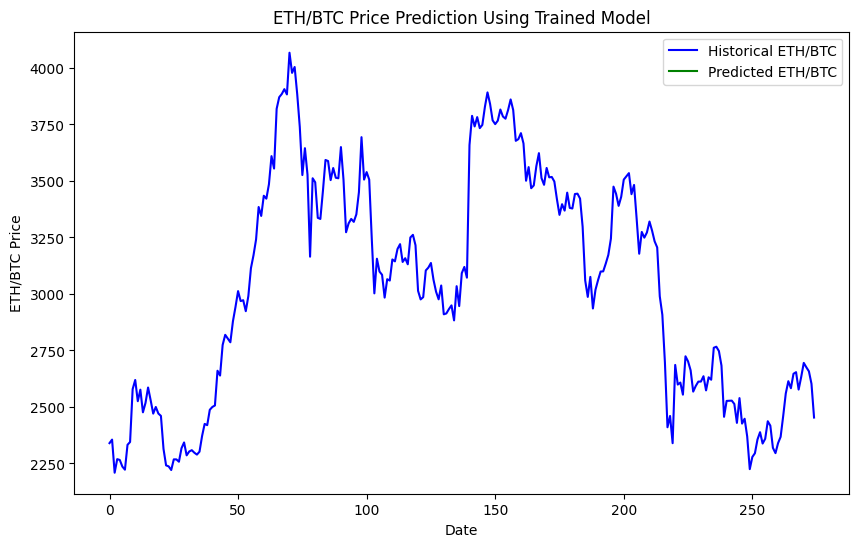

In [115]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt

def rolling_predict(train, test, exog_train, exog_test, window=150):
    preds = []

    # Start predicting from the first point in the test set
    for i in range(len(test)):
        # Define the training data for this iteration
        endog_train = train['ethbtc_close'].iloc[-window:]
        exog_train_current = exog_train.iloc[-window:]

        # Fit the SARIMAX model
        model = SARIMAX(endog_train, exog=exog_train_current, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
        results = model.fit(disp=False)

        # Make the prediction
        pred = results.predict(start=len(endog_train), end=len(endog_train), exog=exog_test.iloc[i:i+1])
        preds.append(pred.values[0])  # Append the prediction to the list

    return preds, results

# Assume 'data' is your DataFrame with the necessary columns
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Exogenous variables
exog_train = train[['ethusdt_close', 'btcusdt_close']]
exog_test = test[['ethusdt_close', 'btcusdt_close']]
pred, results = rolling_predict(train, test, exog_train, exog_test)

# Future Exogenous Variables
fu_exog = df_merged[['ethusdt_close', 'btcusdt_close']]

# Ensure future exogenous variables are numeric
fu_exog = fu_exog.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors to NaN
fu_exog = fu_exog.dropna()  # Drop any rows with NaN values

# Prepare an empty list to hold future predictions
future_preds = []

# Use the last fitted model from the rolling prediction
# Fit the model on the entire training set first
model = SARIMAX(train['ethbtc_close'], exog=exog_train, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
results = model.fit(disp=False)

# Start predicting future values
for i in range(len(fu_exog)):
    # Create the current exogenous variable input
    if i < len(fu_exog):
        # Ensure we have enough previous values
        if i < 150:  # Use the last 'window' rows from the trained model
            current_exog = fu_exog.iloc[:i + 1]  # For first few predictions, use all available data
        else:
            current_exog = fu_exog.iloc[i - 150:i]  # Keep the last 'window' exogenous values

        # Ensure current_exog is shaped correctly
        if len(current_exog) == 150:
            try:
                pred = results.predict(start=len(train) + i, end=len(train) + i, exog=current_exog.iloc[-1:])
                future_preds.append(pred.values[0])
                print(f"Prediction for index {i}: {pred.values[0]}")  # Print the prediction
            except ValueError as e:
                print(f"Error at index {i}: {e}")
                continue

# Convert future predictions to a DataFrame if needed
future_predictions_df = pd.DataFrame(future_preds, columns=['Predicted ETH/BTC'])

# Optionally visualize the future predictions
plt.figure(figsize=(10, 6))
plt.plot(data['ethbtc_close'], label='Historical ETH/BTC', color='blue')
plt.plot(data.index[train_size:train_size + len(future_preds)], future_predictions_df, label='Predicted ETH/BTC', color='green')
plt.title('ETH/BTC Price Prediction Using Trained Model')
plt.xlabel('Date')
plt.ylabel('ETH/BTC Price')
plt.legend()
plt.show()


In [38]:
import numpy as np

# Check for missing values and convert to numeric types
df['ethbtc_close'] = pd.to_numeric(df['ethbtc_close'], errors='coerce')
df['ethusdt_close'] = pd.to_numeric(df['ethusdt_close'], errors='coerce')
df['btcusdt_close'] = pd.to_numeric(df['btcusdt_close'], errors='coerce')

# Drop rows with NaN values that could have been introduced during conversion
df = df.dropna(subset=['ethbtc_close', 'ethusdt_close', 'btcusdt_close'])

# Define rolling window size
window_size = 150

# Initialize a list to store predictions
predictions = []

# Iterate over the dataset starting from index 150 to the end
for i in range(window_size, len(df)):
    # Get the past 150 observations for training
    endog = df['ethbtc_close'].iloc[i-window_size:i].values
    exog = df[['ethusdt_close', 'btcusdt_close']].iloc[i-window_size:i].values

    # Ensure the data is in the correct shape
    endog = np.asarray(endog, dtype=float)
    exog = np.asarray(exog, dtype=float)

    # Define the SARIMAX model (p, d, q) = (2, 1, 2)
    model = SARIMAX(endog, exog=exog, order=(2, 1, 2))

    # Fit the model
    model_fit = model.fit(disp=False)

    # Forecast the next value (for ETH/BTC)
    next_exog = df[['ethusdt_close', 'btcusdt_close']].iloc[i].values.reshape(1, -1)  # next exogenous values for prediction
    pred = model_fit.predict(start=len(endog), end=len(endog), exog=next_exog)

    # Store the prediction
    predictions.append(pred[0])

# Convert predictions into a pandas Series and append to DataFrame
df['predictions'] = pd.Series(predictions, index=df.index[window_size:])

# Display the DataFrame with actual and predicted values
print(df[['timestamp', 'ethbtc_close', 'predictions']].tail())


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

KeyboardInterrupt: 

In [45]:
import pickle
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure the columns are numeric
df['ethbtc_close'] = pd.to_numeric(df['ethbtc_close'], errors='coerce')
df['ethusdt_close'] = pd.to_numeric(df['ethusdt_close'], errors='coerce')
df['btcusdt_close'] = pd.to_numeric(df['btcusdt_close'], errors='coerce')

# Drop rows with NaN values
df = df.dropna(subset=['ethbtc_close', 'ethusdt_close', 'btcusdt_close'])

# Define rolling window size
window_size = 150

# Initialize a list to store predictions
predictions = []

# Saving the last model from the loop
model_fit_to_save = None

# Iterate over the dataset starting from index 150 to the end
for i in range(window_size, len(df)):
    # Get the past 150 observations for training
    endog = df['ethbtc_close'].iloc[i-window_size:i].values
    exog = df[['ethusdt_close', 'btcusdt_close']].iloc[i-window_size:i].values

    # Ensure the data is in the correct shape
    endog = np.asarray(endog, dtype=float)
    exog = np.asarray(exog, dtype=float)

    # Define the SARIMAX model (p, d, q) = (2, 1, 2)
    model = SARIMAX(endog, exog=exog, order=(2, 1, 2))

    # Fit the model
    model_fit = model.fit(disp=False)

    # Save the model at the last iteration to file
    model_fit_to_save = model_fit

    # Forecast the next value (for ETH/BTC)
    next_exog = df[['ethusdt_close', 'btcusdt_close']].iloc[i].values.reshape(1, -1)  # next exogenous values for prediction
    pred = model_fit.predict(start=len(endog), end=len(endog), exog=next_exog)

    # Store the prediction
    predictions.append(pred[0])

# Save the last SARIMAX model to a file
with open('sarimax_model.pkl', 'wb') as model_file:
    pickle.dump(model_fit_to_save, model_file)

# Convert predictions into a pandas Series and append to DataFrame
df['predictions'] = pd.Series(predictions, index=df.index[window_size:])

# Display the DataFrame with actual and predicted values
print(df[['timestamp', 'ethbtc_close', 'predictions']].tail())


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

         timestamp  ethbtc_close  predictions
270  1727395200000       2695.00      2695.00
271  1727481600000       2675.60      2675.60
272  1727568000000       2657.77      2657.77
273  1727654400000       2602.58      2602.58
274  1727740800000       2458.65      2458.65


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [55]:
import pickle
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ensure the columns are numeric
df['ethbtc_close'] = pd.to_numeric(df['ethbtc_close'], errors='coerce')
df['ethusdt_close'] = pd.to_numeric(df['ethusdt_close'], errors='coerce')
df['btcusdt_close'] = pd.to_numeric(df['btcusdt_close'], errors='coerce')

# Drop rows with NaN values
df = df.dropna(subset=['ethbtc_close', 'ethusdt_close', 'btcusdt_close'])

# Define rolling window size
window_size = 150

# Initialize a list to store predictions
predictions = []

# Saving the last model from the loop
model_fit_to_save = None

for i in range(window_size, len(df)):
    # Get the past 150 observations for training
    endog = df['ethbtc_close'].iloc[i-window_size:i].values
    exog = df[['ethusdt_close', 'btcusdt_close']].iloc[i-window_size:i].values

    # Ensure the data is in the correct shape
    endog = np.asarray(endog, dtype=float)
    exog = np.asarray(exog, dtype=float)

    # Define the SARIMAX model (p, d, q) = (2, 1, 2)
    model = SARIMAX(endog, exog=exog, order=(2, 1, 2))

    # Fit the model
    model_fit = model.fit(disp=False)
    model_fit_to_save = model_fit
    # Get the next exogenous values
    next_exog = df[['ethusdt_close', 'btcusdt_close']].iloc[i].values.reshape(1, -1)  # shape should be (1, 2)

    # Forecast the next value (for ETH/BTC)
    pred = model_fit.get_forecast(steps=1, exog=next_exog).predicted_mean

    # Store the prediction
    predictions.append(pred[0])

# Convert predictions into a pandas Series and append to DataFrame
df['predictions'] = pd.Series(predictions, index=df.index[window_size:])


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

In [56]:
# Save the last SARIMAX model to a file
with open('sarimax_model.pkl', 'wb') as model_file:
    pickle.dump(model_fit_to_save, model_file)

# Convert predictions into a pandas Series and append to DataFrame
df['predictions'] = pd.Series(predictions, index=df.index[window_size:])

# Display the DataFrame with actual and predicted values
print(df[['timestamp', 'ethbtc_close', 'predictions']].tail())

         timestamp  ethbtc_close  predictions
270  1727395200000       2695.00      2695.00
271  1727481600000       2675.60      2675.60
272  1727568000000       2657.77      2657.77
273  1727654400000       2602.58      2602.58
274  1727740800000       2453.22      2453.22


In [57]:

# eth_btc_data = GetBinanceData.get_data("ethusdt", timeperiod, startDate=date , endDate=datetime.datetime.now())


1440000
1440000


9999999999999999999999999999999999999999

In [66]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle

# Load your DataFrame and ensure columns are numeric
# df should have been defined and cleaned previously

# Define rolling window size
window_size = 150

# Initialize a list to store predictions
predictions = []
model_fit_to_save = None

for i in range(window_size, len(df)):
    # Get the past 150 observations for training
    endog = df['ethbtc_close'].iloc[i-window_size:i].values
    exog = df[['ethusdt_close', 'btcusdt_close']].iloc[i-window_size:i].values

    # Ensure the data is in the correct shape
    endog = np.asarray(endog, dtype=float)
    exog = np.asarray(exog, dtype=float)

    # Define the SARIMAX model (p, d, q) = (2, 1, 2)
    model = SARIMAX(endog, exog=exog, order=(2, 1, 2))

    # Fit the model
    model_fit = model.fit(disp=False)
    model_fit_to_save = model_fit

    # Prepare next exogenous values for prediction (should be 1 row with 2 columns)
    next_exog = df[['ethusdt_close', 'btcusdt_close']].iloc[i].values.reshape(1, -1)  # shape should be (1, 2)

    # Check the shape of next_exog before prediction
    print("Next exogenous shape:", next_exog.shape)  # Should be (1, 2)

    # Forecast the next value (for ETH/BTC)
    pred = model_fit.get_forecast(steps=1, exog=next_exog).predicted_mean

    # Store the prediction
    predictions.append(pred[0])

# Convert predictions into a pandas Series and append to DataFrame
df['predictions'] = pd.Series(predictions, index=df.index[window_size:])

# Save the model for future predictions
with open('sarimax_model.pkl', 'wb') as file:
    pickle.dump(model_fit_to_save, file)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py

Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py

Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)
Next exogenous shape: (1, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [97]:
date = datetime.datetime(2020, 1, 1)
Future_eth_usdt = GetBinanceData.get_data("ethusdt", timeperiod, startDate=date , endDate=datetime.datetime.now())
Future_btc_usdt = GetBinanceData.get_data("btcusdt", timeperiod, startDate=date , endDate=datetime.datetime.now())
df_Future_eth_usdt= GetBinanceData.data_to_dataframe(Future_eth_usdt)
df_Future_btc_usdt= GetBinanceData.data_to_dataframe(Future_btc_usdt)

1440000
1440000


In [99]:
df_eth_btc.rename(columns={'close': 'ethbtc_close'}, inplace=True)
df_Future_eth_usdt.rename(columns={'close': 'ethusdt_close'}, inplace=True)
df_Future_btc_usdt.rename(columns={'close': 'btcusdt_close'}, inplace=True)

df_merged = pd.merge(df_Future_eth_usdt, df_Future_btc_usdt, on='timestamp', how='inner')

# Make sure all data is sorted by time
df_merged =df_merged.sort_values('timestamp').reset_index(drop=True)

In [101]:
# df_merged[['ethusdt_close', 'btcusdt_close']]
fu_exog = df_merged[['ethusdt_close', 'btcusdt_close']]
for i in range(len(test)):

  exog = exog_train.iloc[-150:]


        # Make the prediction
  pred = results.predict(start=len(df_merged ), end=len(df_merged ), exog=fu_exog.iloc[i:i+1])
  print(pred)
  # preds.append(pred.values[0])  # Append the prediction to the list


ValueError: Provided exogenous values are not of the appropriate shape. Required (1517, 2), got (1, 2).

In [73]:
# Ensure df_merged has the correct columns and convert to a NumPy array
# Selecting only the necessary columns for future predictions
future_exog_data = df_merged[['ethusdt_close', 'btcusdt_close']].values  # Filter for the two columns

# Convert the exogenous data to numeric types (floats)
future_exog_data = future_exog_data.astype(float)

print("Future Exogenous Data:", future_exog_data)

# Use the loaded model to forecast future values
predicted_values = []

for step in range(len(future_exog_data)):
    # Reshape for the model input (should be shape (1, 2))
    next_exog = future_exog_data[step:step+1]  # Keep the shape (1, 2)

    # Forecast the next value using the saved model
    pred = model_fit_to_save.get_forecast(steps=1, exog=next_exog).predicted_mean
    predicted_values.append(pred[0])

# Convert predicted values into a pandas Series
predicted_values_series = pd.Series(predicted_values)

# Display or save the predictions as needed
print(predicted_values_series)


Future Exogenous Data: [[  130.52  7195.65]
 [  127.22  6961.8 ]
 [  133.95  7345.65]
 ...
 [ 2657.77 65670.63]
 [ 2602.58 63291.96]
 [ 2453.54 60788.8 ]]
0        130.52
1        127.22
2        133.95
3        134.02
4        135.23
         ...   
1731    2695.00
1732    2675.60
1733    2657.77
1734    2602.58
1735    2453.54
Length: 1736, dtype: float64


In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure that predicted_values_series is properly created
# Check its length and ensure it matches with actual prices from the DataFrame
# For this example, we will take a slice from the actual prices that matches the predicted values

# Create a DataFrame for actual and predicted prices
# The actual prices should be sliced to match the length of predictions
results_df = pd.DataFrame({
    'Actual': df['ethbtc_close'].iloc[window_size:len(predicted_values_series) + window_size].values,  # Adjust length
    'Predicted': predicted_values_series.values  # Predictions
}, index=df.index[window_size:len(predicted_values_series) + window_size])  # Adjust index

# Plotting the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual Prices', color='blue')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Prices', color='orange', linestyle='--')
plt.title('Actual vs Predicted ETH/BTC Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ValueError: Length of values (1736) does not match length of index (125)

In [60]:
# Load the SARIMAX model from the file
with open('sarimax_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Use the loaded model to make predictions for future data
next_exog = df_merged[['ethusdt_close', 'btcusdt_close']].iloc[-1].values.reshape(1, -1)
future_pred = loaded_model.predict(start=len(df), end=len(df), exog=next_exog)

print(f"Next predicted ETH/BTC close price: {future_pred[0]}")


ValueError: Provided exogenous values are not of the appropriate shape. Required (126, 2), got (1, 2).

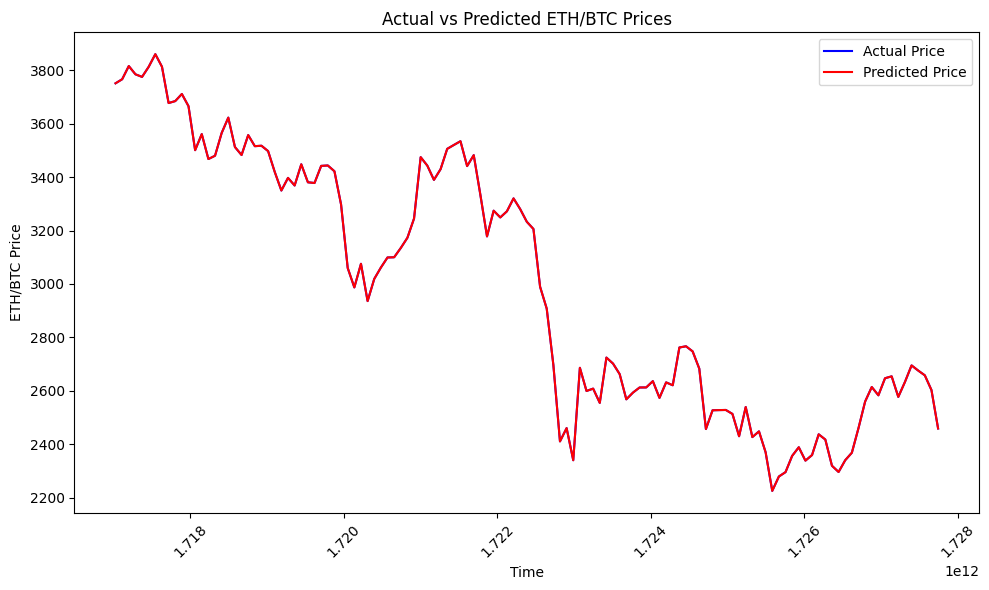

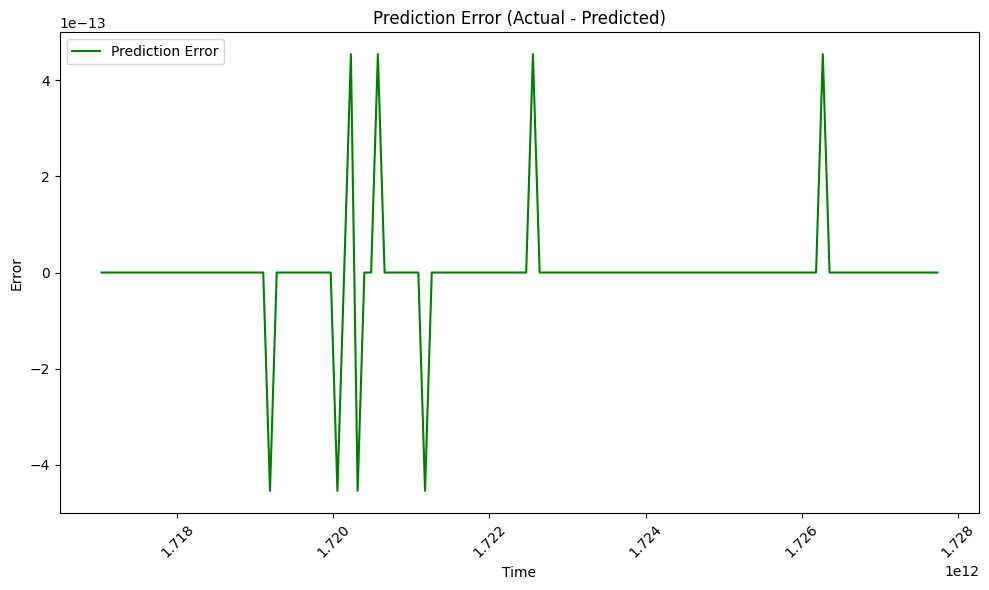

In [23]:
import matplotlib.pyplot as plt


df_cleaned = df.dropna(subset=['ethbtc_close', 'predictions'])


timestamps_for_predictions = df_cleaned['timestamp']


plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['timestamp'], df_cleaned['ethbtc_close'], label='Actual Price', color='blue')
plt.plot(timestamps_for_predictions, df_cleaned['predictions'], label='Predicted Price', color='red')
plt.title('Actual vs Predicted ETH/BTC Prices')
plt.xlabel('Time')
plt.ylabel('ETH/BTC Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 2: Plot Prediction Error (Actual - Predicted)
df_cleaned['prediction_error'] = df_cleaned['ethbtc_close'] - df_cleaned['predictions']

plt.figure(figsize=(10, 6))
plt.plot(timestamps_for_predictions, df_cleaned['prediction_error'], label='Prediction Error', color='green')
plt.title('Prediction Error (Actual - Predicted)')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:



# BackTestdata = GetBinanceData.get_data(symbol, timeperiod, startDate=date , endDate=datetime.datetime.now())
future_eth_usdt = GetBinanceData.get_data("ethusdt", timeperiod, startDate=date , endDate=datetime.datetime.now())
future_btc_usdt = GetBinanceData.get_data("btcusdt", timeperiod, startDate=date , endDate=datetime.datetime.now())

1440000
1440000
1440000


In [ ]:
# future_eth_usdt = np.random.rand(10)  # Replace with your actual future data
# future_btc_usdt = np.random.rand(10)  # Replace with your actual future data


In [ ]:
# Rename the 'close' column to differentiate the data
df_eth_btc.rename(columns={'close': 'ethbtc_close'}, inplace=True)
df_eth_usdt.rename(columns={'close': 'ethusdt_close'}, inplace=True)
df_btc_usdt.rename(columns={'close': 'btcusdt_close'}, inplace=True)

# Merge the data on the timestamp
df = df_eth_btc[['timestamp', 'ethbtc_close']].merge(
    df_eth_usdt[['timestamp', 'ethusdt_close']], on='timestamp'
).merge(
    df_btc_usdt[['timestamp', 'btcusdt_close']], on='timestamp'
)

# Make sure all data is sorted by time
df = df.sort_values('timestamp').reset_index(drop=True)

In [ ]:
timeperiod = '1d'
startDate = datetime.datetime(2023, 1, 1)

eth_btc = GetBinanceData.get_data("ethbtc", timeperiod, startDate=startDate, endDate=datetime.datetime.now())
eth_usdt = GetBinanceData.get_data("ethusdt", timeperiod, startDate=startDate, endDate=datetime.datetime.now())
btc_usdt = GetBinanceData.get_data("btcusdt", timeperiod, startDate=startDate, endDate=datetime.datetime.now())
# Convert data to DataFrames
eth_btc_df = GetBinanceData.data_to_dataframe(eth_btc)
eth_usdt_df = GetBinanceData.data_to_dataframe(eth_usdt)
btc_usdt_df = GetBinanceData.data_to_dataframe(btc_usdt)

eth_btc_df.reset_index(drop=True, inplace=True)
eth_usdt_df.reset_index(drop=True, inplace=True)
btc_usdt_df.reset_index(drop=True, inplace=True)

1440000
1440000
1440000


In [ ]:
def create_dataset(Y, X, lookahead=150):
    """ Create dataset for training based on future prices. """
    Y_values = Y
    X_values = X

    # Number of observations
    n = len(Y_values)

    # Prepare a DataFrame to hold the data
    data = []

    for i in range(n - lookahead):
        # Next 150 prices
        target = Y_values[i]  # Current price (to predict)
        features = Y_values[i + 1:i + lookahead + 1]  # Next 150 prices
        exog = X_values[i + 1:i + lookahead + 1].flatten()  # Next 150 exogenous features

        # Combine target, features, and exogenous variables
        data.append([target] + features.tolist() + exog.tolist())

    # Convert to DataFrame
    # Columns: Target + Prices for the next lookahead + Exogenous features
    columns = ['Target'] + [f'Price_{j}' for j in range(1, lookahead + 1)] + [f'eth_usdt_{j}' for j in range(1, lookahead + 1)] + [f'btc_usdt_{j}' for j in range(1, lookahead + 1)]

    dataset = pd.DataFrame(data, columns=columns)

    return dataset

def train_and_predict(Y, X, lookahead=150):
    """ Train SARIMAX model based on the transformed dataset. """
    # Create the dataset for training
    dataset = create_dataset(Y, X, lookahead)

    # Split dataset into features and target
    Y_train = dataset['Target']
    X_train = dataset.drop(columns='Target')

    # Fit the SARIMAX model
    model = sm.tsa.SARIMAX(Y_train, exog=X_train, order=(1,1 , 1))
    model_fit = model.fit(disp=False)

    # Make predictions for the next 150 prices
    predictions = model_fit.forecast(steps=150, exog=X_train.iloc[-150:])  # Use last known exogenous values

    return predictions, dataset , model_fit
# //////////////////
for df, name in zip([eth_btc_df, eth_usdt_df, btc_usdt_df], ['eth_btc', 'eth_usdt', 'btc_usdt']):
    if 'close' not in df.columns:
        raise ValueError(f"{name} DataFrame must contain 'close' column")

    # Convert timestamps from milliseconds to datetime and set as index
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Adjust this line if your timestamp column is named differently
    df.set_index('timestamp', inplace=True)
    df = df.resample('D').ffill()  # Forward fill to handle missing dates if any
    df.index.freq = 'D'  # Explicitly set the frequency to daily
Y = eth_btc_df['close']
X = pd.concat([eth_usdt_df['close'], btc_usdt_df['close']], axis=1)  # Exogenous variables
X.columns = ['eth_usdt', 'btc_usdt']

# Ensure the frequency is set to daily
Y = Y.asfreq('D')
X = X.asfreq('D')

# Log shapes
print("Shape of Y (ETH/BTC):", Y.shape)
print("Shape of X (Exogenous):", X.shape)
Y = pd.to_numeric(Y, errors='coerce')
X = X.apply(pd.to_numeric, errors='coerce')
print("Missing values in Y (Target):", Y.isnull().sum())
print("Missing values in X (Exogenous):", X.isnull().sum())

# Normalize indices
Y.index = pd.to_datetime(Y.index).normalize()  # Normalize to remove time component if present
X.index = pd.to_datetime(X.index).normalize()

# Set frequency to Daily
Y = Y.asfreq('D')  # Set frequency to daily
X = X.asfreq('D')  # Set frequency to daily
Y.index.freq = 'D'  # Ensure frequency is explicitly set
X.index.freq = 'D'  # Ensure frequency is explicitly set
# Ensure Y is numeric
Y = pd.to_numeric(Y, errors='coerce')

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Check for any missing values after conversion
print("Missing values in Y after conversion:", Y.isnull().sum())
print("Missing values in X after conversion:\n", X.isnull().sum())

# Drop rows with missing values if any
if Y.isnull().any():
    Y = Y.dropna()
if X.isnull().any().any():
    X = X.dropna()

# Align Y and X lengths
if len(Y) != len(X):
    min_length = min(len(Y), len(X))
    Y = Y.iloc[:min_length]
    X = X.iloc[:min_length]

# Reset indices
Y = Y.reset_index(drop=True)
X = X.reset_index(drop=True)

# Verify the data types
print("Y data type:", Y.dtype)
print("X data types:\n", X.dtypes)

# Convert Y and X to numpy arrays
Y_np = Y.values
X_np = X.values

# Run the training and prediction function again with numpy arrays
predicted_prices, dataset , model_fit = train_and_predict(Y_np, X_np)

# Prepare the DataFrame for results
results_df = pd.DataFrame({
    'Actual Prices': Y_np[-150:],  # Assuming you want the last 150 actual prices
    'Predicted Prices': predicted_prices
})

# Calculate prediction error and RMSE
results_df['Prediction Error'] = results_df['Actual Prices'] - results_df['Predicted Prices']
rmse = np.sqrt(np.mean((results_df['Actual Prices'] - results_df['Predicted Prices']) ** 2))

# Display the results
print("Prediction Errors:")
print(results_df[['Actual Prices', 'Predicted Prices', 'Prediction Error']])
print(f"\nRoot Mean Squared Error (RMSE): {rmse:.4f}")




Shape of Y (ETH/BTC): (639,)
Shape of X (Exogenous): (639, 2)
Missing values in Y (Target): 0
Missing values in X (Exogenous): eth_usdt    0
btc_usdt    0
dtype: int64
Missing values in Y after conversion: 0
Missing values in X after conversion:
 eth_usdt    0
btc_usdt    0
dtype: int64
Y data type: float64
X data types:
 eth_usdt    float64
btc_usdt    float64
dtype: object


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Prediction Errors:
     Actual Prices  Predicted Prices  Prediction Error
489        0.04890          0.050867         -0.001967
490        0.04906          0.053829         -0.004769
491        0.04859          0.053084         -0.004494
492        0.04836          0.053184         -0.004824
493        0.04861          0.053336         -0.004726
..             ...               ...               ...
634        0.04042          0.050352         -0.009932
635        0.04109          0.049609         -0.008519
636        0.04074          0.051098         -0.010358
637        0.04032          0.050622         -0.010302
638        0.04095          0.049348         -0.008398

[150 rows x 3 columns]

Root Mean Squared Error (RMSE): 0.0063


In [ ]:
import pickle

def save_model(model, filename):
    """ Save the trained model to a file. """
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

# Call the function to save the model
save_model(model_fit, "sarimax_model.pkl")


In [ ]:
import pickle

def load_sarimax_model(model_file):
    """Load the SARIMAX model from a file."""
    with open(model_file, 'rb') as f:
        loaded_model = pickle.load(f)
    return loaded_model


loaded_model = load_sarimax_model('sarimax_model.pkl')


In [ ]:
# Use the loaded model to forecast future prices
predicted_future_prices = loaded_model.forecast(steps=len(X_future), exog=X_future)

# Prepare a DataFrame for future predicted prices
future_results_df = pd.DataFrame({
    'Future Dates': future_dates,
    'Predicted Prices': predicted_future_prices
})

print(future_results_df)

ValueError: Provided exogenous values are not of the appropriate shape. Required (1735, 450), got (1735, 2).

In [ ]:

pf = vbt.Portfolio.from_signals(
    close=BackTestdata['close'],
    entries=buy_signal,

    tp_stop=0.01,
    init_cash=10000,
    freq='1D',  # 5 minutes
    sl_stop=0.02,  # Stoploss at -20%
    sl_trail=True,

)

# Performance metrics
print(pf.stats())

# Plot the results
pf.plot().show()

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle

# Assuming your data is in a DataFrame called df with these columns: 'ethbtc', 'ethusdt', 'btcusdt'
# eth_btc = GetBinanceData.get_data("ethbtc", timeperiod, startDate=startDate, endDate=datetime.datetime.now())
# eth_usdt = GetBinanceData.get_data("ethusdt", timeperiod, startDate=startDate, endDate=datetime.datetime.now())
# btc_usdt = GetBinanceData.get_data("btcusdt", timeperiod, startDate=startDate, endDate=datetime.datetime.now())

df['ethbtc'] =
# Set the number of past observations to use for training (rolling window size)
window_size = 150

# Initialize empty list to store predictions
predictions = []

# Training the model with past 150 observations
for i in range(window_size, len(df)):
    # Get the past 150 observations for training
    endog = df['ethbtc'].iloc[i-window_size:i]  # target variable: ETH/BTC
    exog = df[['ethusdt', 'btcusdt']].iloc[i-window_size:i]  # exogenous variables: ETH/USDT, BTC/USDT

    # Define the SARIMAX model (p, d, q) = (2, 1, 2)
    model = SARIMAX(endog, exog=exog, order=(2, 1, 2))

    # Fit the model
    model_fit = model.fit(disp=False)

    # Save the model to a file (for example, after the final iteration)
    if i == len(df) - 1:
        with open('sarimax_model.pkl', 'wb') as f:
            pickle.dump(model_fit, f)

# Model is now saved in 'sarimax_model.pkl'
